Вывод пройденного расстояния за период (в разбивке по
дням);

- Вывод количества выполненных заказов за период (в
разбивке по дням);
- Время проведенное в движении за период (в разбивке по
дням);
- Время простоя за период (в разбивке по дням);
- Время нахождения в каждом из статусов за период.


In [1]:
import pandas as pd
from clickhouse_driver import Client


In [2]:
client = Client(host='75.119.142.124', port=9035, user='default', password='qolkasw10-=', database='default')


In [3]:
# parametered SQL query to fetch data
table = "main_data_stg"
db = "default"
params = {
'forklit' : [0],
'warehouse' :  [ 1],
# _ts = YYYY-MM-DD HH:mm
'from_ts' : "2023-10-21 12:42:00.000",
'to_ts' : "2023-10-25 12:45:00.000",
}
query = f'''
SELECT *
FROM {db}.{table}
WHERE id_forklift in %(forklit)s 
and id_warehouse in  %(warehouse)s
and event_timestamp BETWEEN %(from_ts)s and %(to_ts)s
ORDER by event_timestamp ASC ;
'''

In [4]:
print(query)


SELECT *
FROM default.main_data_stg
WHERE id_forklift in %(forklit)s 
and id_warehouse in  %(warehouse)s
and event_timestamp BETWEEN %(from_ts)s and %(to_ts)s
ORDER by event_timestamp ASC ;



In [5]:
result = client.execute(query, params=params)

# Convert the result to a Pandas DataFrame
df = pd.DataFrame(result, columns=[desc[0] for desc in client.execute(f"DESCRIBE {db}.{table}")])


In [6]:
df

,status,id_forklift,id_warehouse,id_task,id_point,event_timestamp
0,START,0,1,1,K1,2023-10-21 13:51:36.142
1,WORK,0,1,1,K1,2023-10-21 13:51:36.449
2,WORK,0,1,1,K2,2023-10-21 13:51:41.447
3,WORK,0,1,1,K5,2023-10-21 13:51:46.434
4,START,0,1,1,K1,2023-10-21 17:06:47.841
...,...,...,...,...,...,...
252,WORK_UP,0,1,5,K2,2023-10-22 13:41:39.696
253,WORK_UP,0,1,5,K3,2023-10-22 13:41:50.343
254,TARGET,0,1,5,X1,2023-10-22 13:41:50.420
255,WORK_DOWN,0,1,5,K3,2023-10-22 13:41:51.996


In [7]:
# configs.py file
# Справочник маршрутов погрузчиков по складу.
# Каждый маршрут имеет id, id целевого стеллажа, а также набор контрольных точек.
# Каждая контрольная точка имеет свой id, имя, а также расстояние до следующей КТ
path_lib = {
    1: {"path_sequence": [
            {"check_point_id": 1,
             "check_point_name": "K1",
             "next_check_point_distance": 5},
            {"check_point_id": 2,
             "check_point_name": "K2",
             "next_check_point_distance": 10},
            {"check_point_id": 3,
             "check_point_name": "K3",
             "next_check_point_distance": 10}
        ],
        "target_rack_id": "X1"},
    2: {"path_sequence": [
            {"check_point_id": 1,
             "check_point_name": "K1",
             "next_check_point_distance": 5},
            {"check_point_id": 2,
             "check_point_name": "K2",
             "next_check_point_distance": 10},
            {"check_point_id": 3,
             "check_point_name": "K3",
             "next_check_point_distance": 15},
            {"check_point_id": 4,
             "check_point_name": "K4",
             "next_check_point_distance": 10}
        ],
        "target_rack_id": "X2"},
    3: {"path_sequence": [
            {"check_point_id": 1,
             "check_point_name": "K1",
             "next_check_point_distance": 5},
            {"check_point_id": 2,
             "check_point_name": "K2",
             "next_check_point_distance": 5},
            {"check_point_id": 5,
             "check_point_name": "K5",
             "next_check_point_distance": 10},
            {"check_point_id": 6,
             "check_point_name": "K6",
             "next_check_point_distance": 10}
        ],
        "target_rack_id": "X3"},
    4: {"path_sequence": [
            {"check_point_id": 1,
             "check_point_name": "K1",
             "next_check_point_distance": 5},
            {"check_point_id": 2,
             "check_point_name": "K2",
             "next_check_point_distance": 5},
            {"check_point_id": 5,
             "check_point_name": "K5",
             "next_check_point_distance": 10},
            {"check_point_id": 6,
             "check_point_name": "K6",
             "next_check_point_distance": 15},
            {"check_point_id": 7,
             "check_point_name": "K7",
             "next_check_point_distance": 10}
        ],
        "target_rack_id": "X4"},
    5: {"path_sequence": [
            {"check_point_id": 1,
             "check_point_name": "K1",
             "next_check_point_distance": 5},
            {"check_point_id": 2,
             "check_point_name": "K2",
             "next_check_point_distance": 5},
            {"check_point_id": 5,
             "check_point_name": "K5",
             "next_check_point_distance": 5},
            {"check_point_id": 8,
             "check_point_name": "K8",
             "next_check_point_distance": 10},
            {"check_point_id": 9,
             "check_point_name": "K9",
             "next_check_point_distance": 5}
        ],
        "target_rack_id": "X5"},
    6: {"path_sequence": [
            {"check_point_id": 1,
             "check_point_name": "K1",
             "next_check_point_distance": 5},
            {"check_point_id": 2,
             "check_point_name": "K2",
             "next_check_point_distance": 5},
            {"check_point_id": 5,
             "check_point_name": "K5",
             "next_check_point_distance": 5},
            {"check_point_id": 8,
             "check_point_name": "K8",
             "next_check_point_distance": 10},
            {"check_point_id": 9,
             "check_point_name": "K9",
             "next_check_point_distance": 15},
            {"check_point_id": 10,
             "check_point_name": "K10",
             "next_check_point_distance": 10}
        ],
        "target_rack_id": "X6"}
}

# cities list
cities = [
    "Rostov-on-Don",
    "Moscow",
    "Krasnodar",
    "Tver",
    "Saint Petersburg",
    "Almaty"
]


In [8]:
# Generate a map of dists 
dists = {}
for id, path in path_lib.items():
    curr_pos =  path['path_sequence'][0]['check_point_name']
    next_dist = path['path_sequence'][0]['next_check_point_distance']
    for next_detail in path['path_sequence'][1:]:
        next_pos = next_detail['check_point_name']
        if curr_pos not in dists:
            dists[curr_pos] = {curr_pos:0}
        if next_pos not in dists:
            dists[next_pos] = {next_pos:0}
        dists[curr_pos][next_pos] = next_dist
        dists[next_pos][curr_pos] = next_dist
        curr_pos = next_pos
        next_dist = next_detail['next_check_point_distance']
    if curr_pos not in dists:
        dists[curr_pos] = {curr_pos:0}
    if path["target_rack_id"] not in dists:
        dists[path["target_rack_id"]] = {path["target_rack_id"]:0}
    dists[curr_pos][path["target_rack_id"]] = next_dist
    dists[path["target_rack_id"]][curr_pos] = next_dist



In [9]:
def get_dist(s, f):
    dist = 0
    curr_node = s
    stack = [(s, 0)]
    node___visited = set()
    while stack:
        curr_node, curr_dist = stack.pop()
        if curr_node in node___visited:
            continue
        if curr_node == f:
            return curr_dist
        for neigh in dists.get(curr_node, {}):
            stack.append((neigh, curr_dist + dists[curr_node][neigh]))
        node___visited.add(curr_node)

all_dists = {}
for k1 in dists:
    for k2 in dists:
        if k1 not in all_dists:
            all_dists[k1] = {}
        all_dists[k1][k2] = get_dist(k1,k2)

all_dists

{'K1': {'K1': 0,
  'K2': 5,
  'K3': 15,
  'X1': 25,
  'K4': 30,
  'X2': 40,
  'K5': 10,
  'K6': 20,
  'X3': 30,
  'K7': 35,
  'X4': 45,
  'K8': 15,
  'K9': 25,
  'X5': 30,
  'K10': 40,
  'X6': 50},
 'K2': {'K1': 5,
  'K2': 0,
  'K3': 10,
  'X1': 20,
  'K4': 25,
  'X2': 35,
  'K5': 5,
  'K6': 15,
  'X3': 25,
  'K7': 30,
  'X4': 40,
  'K8': 10,
  'K9': 20,
  'X5': 25,
  'K10': 35,
  'X6': 45},
 'K3': {'K1': 15,
  'K2': 10,
  'K3': 0,
  'X1': 10,
  'K4': 15,
  'X2': 25,
  'K5': 15,
  'K6': 25,
  'X3': 35,
  'K7': 40,
  'X4': 50,
  'K8': 20,
  'K9': 30,
  'X5': 35,
  'K10': 45,
  'X6': 55},
 'X1': {'K1': 25,
  'K2': 20,
  'K3': 10,
  'X1': 0,
  'K4': 25,
  'X2': 35,
  'K5': 25,
  'K6': 35,
  'X3': 45,
  'K7': 50,
  'X4': 60,
  'K8': 30,
  'K9': 40,
  'X5': 45,
  'K10': 55,
  'X6': 65},
 'K4': {'K1': 30,
  'K2': 25,
  'K3': 15,
  'X1': 25,
  'K4': 0,
  'X2': 10,
  'K5': 30,
  'K6': 40,
  'X3': 50,
  'K7': 55,
  'X4': 65,
  'K8': 35,
  'K9': 45,
  'X5': 50,
  'K10': 60,
  'X6': 70},
 'X2': {

In [10]:
# Вывод количества выполненных заказов за период (в разбивке по дням)

# parametered SQL query to fetch data
params = {
'forklit' : [0],
'warehouse' :  [1],
# _ts = YYYY-MM-DD HH:mm
'from_ts' : "2023-10-21 12:42:00.000",
'to_ts' : "2023-10-25 12:45:00.000",
}
query = f'''
SELECT COUNT(*)
FROM {db}.{table}
WHERE id_forklift in %(forklit)s 
and id_warehouse in  %(warehouse)s
and event_timestamp BETWEEN %(from_ts)s and %(to_ts)s
and status = 'FINISH'
'''
result = client.execute(query, params=params)
result

[(14,)]

In [11]:
# Время простоя за период (в разбивке по дням);
# Время проведенное в движении за период (в разбивке по дням);
# parametered SQL query to fetch data
params = {
'forklit' : [0],
'warehouse' :  [1],
# _ts = YYYY-MM-DD HH:mm
'from_ts' : "2023-10-21 12:42:00.000",
'to_ts' : "2023-10-25 12:45:00.000",
}
query = f'''
SELECT *
FROM {db}.{table}
WHERE id_forklift in %(forklit)s 
and id_warehouse in  %(warehouse)s
and event_timestamp BETWEEN %(from_ts)s and %(to_ts)s
AND (status IN ('FINISH','START')) 
ORDER by event_timestamp ASC ;
'''
result = client.execute(query, params=params)

# Convert the result to a Pandas DataFrame
df = pd.DataFrame(result, columns=[desc[0] for desc in client.execute(f"DESCRIBE {db}.{table}")])

code_map = {
    'START':0, 'FINISH':1
}
df['status_code'] = df.status.apply(lambda x: code_map.get(x, 2))
df['diff'] = df.status_code.diff().ne(0).cumsum()
df = df.groupby('diff').agg('max')
df = df.reset_index()
# leave only start/finish events. assume the rover moves all the time, while not on k1 station
idle_time = (df['event_timestamp'] - df['event_timestamp'].shift(1)).sum() 
if df['status'][0] == 'START':
    idle_time = (df['event_timestamp'] - df['event_timestamp'].shift(1))[1::2].sum()
else:
    idle_time (df['event_timestamp'] - df['event_timestamp'].shift(1))[::2].sum()
busy_time = df['event_timestamp'].max() - df['event_timestamp'].min() - idle_time
idle_time, busy_time

(Timedelta('0 days 00:16:13.624000'), Timedelta('0 days 15:08:24.673000'))

In [13]:
# Вывод пройденного расстояния за период (в разбивке по дням);
params = {
'forklit' : [0],
'warehouse' :  [1],
# _ts = YYYY-MM-DD HH:mm
'from_ts' : "2023-10-21 12:42:00.000",
'to_ts' : "2023-10-25 12:45:00.000",
}
query = f'''
SELECT *
FROM {db}.{table}
WHERE id_forklift in %(forklit)s 
and id_warehouse in  %(warehouse)s
and event_timestamp BETWEEN %(from_ts)s and %(to_ts)s
ORDER by event_timestamp ASC ;
'''
result = client.execute(query, params=params)

# Convert the result to a Pandas DataFrame
df = pd.DataFrame(result, columns=[desc[0] for desc in client.execute(f"DESCRIBE {db}.{table}")])
df['id_next_point'] = df.id_point.shift(-1)

df['dist'] = df.apply(lambda row: all_dists[row['id_point']].get(row['id_next_point'],0),axis=1)
df['dist'].sum()

1605

In [15]:
# Время нахождения в каждом из статусов за период.
params = {
'forklit' : [0],
'warehouse' :  [1],
# _ts = YYYY-MM-DD HH:mm
'from_ts' : "2023-10-21 12:42:00.000",
'to_ts' : "2023-10-25 12:45:00.000",
}
query = f'''
SELECT *
FROM {db}.{table}
WHERE id_forklift in %(forklit)s 
and id_warehouse in  %(warehouse)s
and event_timestamp BETWEEN %(from_ts)s and %(to_ts)s
ORDER by event_timestamp ASC ;
'''
result = client.execute(query, params=params)

# Convert the result to a Pandas DataFrame
df = pd.DataFrame(result, columns=[desc[0] for desc in client.execute(f"DESCRIBE {db}.{table}")])
resps = df[df['status'] != df['status'].shift()]
resps['time_in_state'] = resps['event_timestamp'] - df['event_timestamp'].shift()
resps.groupby(['status', 'id_forklift', 'id_warehouse']).aggregate({'time_in_state': 'sum' })

/tmp/ipykernel_711277/453076725.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resps['time_in_state'] = resps['event_timestamp'] - df['event_timestamp'].shift()


,,,time_in_state
status,id_forklift,id_warehouse,
FINISH,0,1,0 days 00:00:58.431000
START,0,1,0 days 23:05:57.810000
TARGET,0,1,0 days 00:00:00.442000
WORK,0,1,0 days 00:00:04.991000
WORK_DOWN,0,1,0 days 00:00:12.543000
WORK_UP,0,1,0 days 00:00:06.293000


In [16]:
resps['day'] = resps['event_timestamp'].dt.strftime('%Y-%m-%d')
resps.groupby(['status', 'id_forklift', 'id_warehouse', 'day']).aggregate({'time_in_state': 'sum' })

/tmp/ipykernel_711277/3054636783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resps['day'] = resps['event_timestamp'].dt.strftime('%Y-%m-%d')


time_in_state
status    id_forklift id_warehouse day                              
FINISH    0           1            2023-10-21 0 days 00:00:24.235000
                                   2023-10-22 0 days 00:00:34.196000
START     0           1            2023-10-21 0 days 09:34:34.955000
                                   2023-10-22 0 days 13:31:22.855000
TARGET    0           1            2023-10-22 0 days 00:00:00.442000
WORK      0           1            2023-10-21 0 days 00:00:02.975000
                                   2023-10-22 0 days 00:00:02.016000
WORK_DOWN 0           1            2023-10-22 0 days 00:00:12.543000
WORK_UP   0           1            2023-10-22 0 days 00:00:06.293000

<Axes: xlabel='status,id_forklift,id_warehouse,day'>

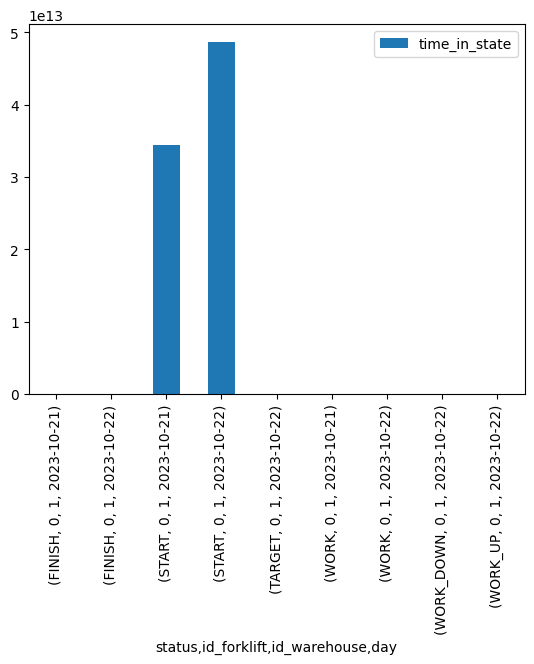

In [20]:
resps.groupby(['status', 'id_forklift', 'id_warehouse', 'day']).aggregate({'time_in_state': 'sum' }).plot(kind='bar')